# Semantic Segmentation using U-NET model

In [6]:
! pip install -q kaggle albumentations==1.0.3 
!pip install torch==1.8.1 torchtext==0.9.1 torchvision==0.9.1 -q
!pip install pytorch_lightning==1.3.3 -q

     |████████████████████████████████| 7.1 MB 7.5 MB/s 
     |████████████████████████████████| 17.4 MB 108 kB/s 


In [2]:
from google.colab import files

In [3]:
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [4]:
!mkdir -p .pytorch/carvanasemseg/
!kaggle competitions download -c carvana-image-masking-challenge -f train.zip -p .pytorch/carvanasemseg/
!kaggle competitions download -c carvana-image-masking-challenge -f train_masks.zip -p .pytorch/carvanasemseg/
!kaggle competitions download -c carvana-image-masking-challenge -f train_masks.csv.zip -p .pytorch/carvanasemseg/

 97% 392M/405M [00:04<00:00, 180MB/s]
100% 405M/405M [00:04<00:00, 99.4MB/s]
 17% 5.00M/29.1M [00:00<00:01, 20.1MB/s]
100% 29.1M/29.1M [00:00<00:00, 83.9MB/s]
 33% 5.00M/15.3M [00:00<00:00, 40.8MB/s]
100% 15.3M/15.3M [00:00<00:00, 74.9MB/s]


In [5]:
!python -m zipfile -e .pytorch/carvanasemseg/train.zip  .pytorch/carvanasemseg/
!python -m zipfile -e .pytorch/carvanasemseg/train_masks.zip  .pytorch/carvanasemseg/
!python -m zipfile -e .pytorch/carvanasemseg/train_masks.csv.zip .pytorch/carvanasemseg/

## Import libraries

In [1]:
# visualization library
import cv2
from matplotlib import pyplot as plt
# data storing library
import numpy as np
import pandas as pd
# torch libraries
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from torchvision import transforms
import pytorch_lightning as pl
# architecture and data split library
from sklearn.model_selection import train_test_split
# augmentation library
import albumentations 
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensorV2
import os
import pdb
import time
import warnings
import random
from tqdm import tqdm_notebook as tqdm
import concurrent.futures

# warning print supression
warnings.filterwarnings("ignore")
import PIL

## Preprocessing

### Fixing seed value

In [2]:
def setSeed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


setSeed(42)

In [8]:
!mkdir -p '.pytorch/carvanasemseg/'
!mkdir -p '.pytorch/carvanasemseg/train_masks_png/'
!mkdir -p '.pytorch/carvanasemseg/train-128/'
!mkdir -p '.pytorch/carvanasemseg/train_masks-128/'

def convert_img(fn):
    PIL.Image.open(f'.pytorch/carvanasemseg/train_masks/{fn}').save(
        f'.pytorch/carvanasemseg/train_masks_png/{fn[:-4]}.png')  #opening and saving image


fns = os.listdir('.pytorch/carvanasemseg/train_masks')
with concurrent.futures.ThreadPoolExecutor(8) as e:
    e.map(convert_img, fns)


def resize_mask(fn):
    PIL.Image.open('.pytorch/carvanasemseg/train_masks_png/' + fn).resize((128, 128)).save(
        f'.pytorch/carvanasemseg/train_masks-128/{fn}')


fns = os.listdir('.pytorch/carvanasemseg/train_masks_png/')
with concurrent.futures.ThreadPoolExecutor(8) as e:
    e.map(resize_mask, fns)


# we convert the high resolution input image to 128*128
def resize_img(fn):
    PIL.Image.open('.pytorch/carvanasemseg/train/' + fn).resize((128, 128)).save(
        f'.pytorch/carvanasemseg/train-128/{fn}')


fns = os.listdir('.pytorch/carvanasemseg/train/')
with concurrent.futures.ThreadPoolExecutor(8) as e:
    e.map(resize_img, fns)

In [3]:
df = pd.read_csv('.pytorch/carvanasemseg/train_masks.csv')
# location of original and mask image
img_fol = '.pytorch/carvanasemseg/train-128/'
mask_fol = '.pytorch/carvanasemseg/train_masks-128/'
# imagenet mean/std will be used as the resnet backbone is trained on imagenet stats
mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

In [4]:
df.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


### Transformation

In [5]:
# input-->"phase",mean,std
# output-->list
def get_transform(phase, mean, std):
    list_trans = []
    if phase == 'train':  # only flip during training
        list_trans.extend([HorizontalFlip(p=0.5)])
    list_trans.extend(
        [Normalize(mean=mean, std=std, p=1), ToTensorV2()])  #normalizing the data & then converting to tensors
    list_trans = Compose(list_trans)
    return list_trans

### Dataset and Dataloader

In [6]:

class CarDataset(Dataset):
    def __init__(self, df, img_fol, mask_fol, mean, std, phase):
        self.fname = df['img'].values.tolist()
        self.img_fol = img_fol
        self.mask_fol = mask_fol
        self.mean = mean
        self.std = std
        self.phase = phase
        self.trasnform = get_transform(phase, mean, std)

    def __getitem__(self, idx):
        name = self.fname[idx]
        img_name_path = os.path.join(self.img_fol, name)
        mask_name_path = os.path.join(self.mask_fol, name.replace('.jpg', '_mask.png'))
        img = cv2.imread(img_name_path)
        mask = cv2.imread(mask_name_path, cv2.IMREAD_GRAYSCALE)
        mask = np.where(mask==255, 1, 0)
        augmentation = self.trasnform(image=img, mask=mask)
        img_aug = augmentation['image'].type(torch.float32)  #[3,128,128] type:Tensor
        mask_aug = augmentation['mask'].type(torch.int64)    #[1,128,128] type:Tensor
        return img_aug, mask_aug

    def __len__(self):
        return len(self.fname)

In [7]:
def CarDataloader(df, img_fol, mask_fol, mean, std, batch_size, num_workers):
    df_train, df_valid = train_test_split(df, test_size=0.2, random_state=69)
    traindataset = CarDataset(df_train, img_fol, mask_fol, mean, std, 'train')
    traindataloader = DataLoader(traindataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True)
    valdataset = CarDataset(df_valid, img_fol, mask_fol, mean, std, 'test')
    valdataloader = DataLoader(valdataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True)

    return traindataloader, valdataloader

In [32]:
NUM_WORKER = 0
BATCH_SIZE = 1
train_dl, val_dl = CarDataloader(df, img_fol, mask_fol, mean, std, batch_size=BATCH_SIZE, num_workers=NUM_WORKER)

In [9]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([1, 3, 128, 128]), torch.Size([1, 128, 128]))

## UNET Model

In [10]:
class UNET(pl.LightningModule):
    def __init__(self, in_channels, out_channels, lr=0.01):
        super().__init__()
        self.learning_rate = lr
        self.loss = nn.CrossEntropyLoss()
        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64 * 2, 32, 3, 1)
        self.upconv1 = self.expand_block(32 * 2, out_channels, 3, 1)

    def contract_block(self, in_channels, out_channels, kernel_size, padding):
        contract = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):
        expand = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        )
        return expand

    def forward(self, x):
        # down-sampling
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        # upsampling
        upconv3 = self.upconv3(conv3)
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def train_dataloader(self):
        return CarDataloader(df, img_fol, mask_fol, mean, std, batch_size=BATCH_SIZE, num_workers=NUM_WORKER)[0]

    def val_dataloader(self):
        return CarDataloader(df, img_fol, mask_fol, mean, std, batch_size=BATCH_SIZE, num_workers=NUM_WORKER)[1]

    def test_dataloader(self):
        return CarDataloader(df, img_fol, mask_fol, mean, std, batch_size=BATCH_SIZE, num_workers=NUM_WORKER)[1]

    def training_step(self, batch, batch_idx):
        x, y = batch

        outputs = self(x)
        loss = F.cross_entropy(outputs, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        loss = self.loss(outputs, y)
        acc = (outputs.argmax(dim=1) == y).float().mean()

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

In [11]:
unet = UNET(3, 2)

## training

In [12]:
AVAIL_GPUS = min(1, torch.cuda.device_count())
trainer = pl.Trainer(
    gpus=AVAIL_GPUS,
    max_epochs=50,
    progress_bar_refresh_rate=20,
    # accumulate_grad_batches=0,
    gradient_clip_val=5
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [13]:
trainer.fit(unet)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | loss    | CrossEntropyLoss | 0     
1 | conv1   | Sequential       | 55.1 K
2 | conv2   | Sequential       | 55.7 K
3 | conv3   | Sequential       | 221 K 
4 | upconv3 | Sequential       | 147 K 
5 | upconv2 | Sequential       | 55.5 K
6 | upconv1 | Sequential       | 1.2 K 
---------------------------------------------
537 K     Trainable params
0         Non-trainable params
537 K     Total params
2.149     Total estimated model params size (MB)


## Visualization

In [25]:
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

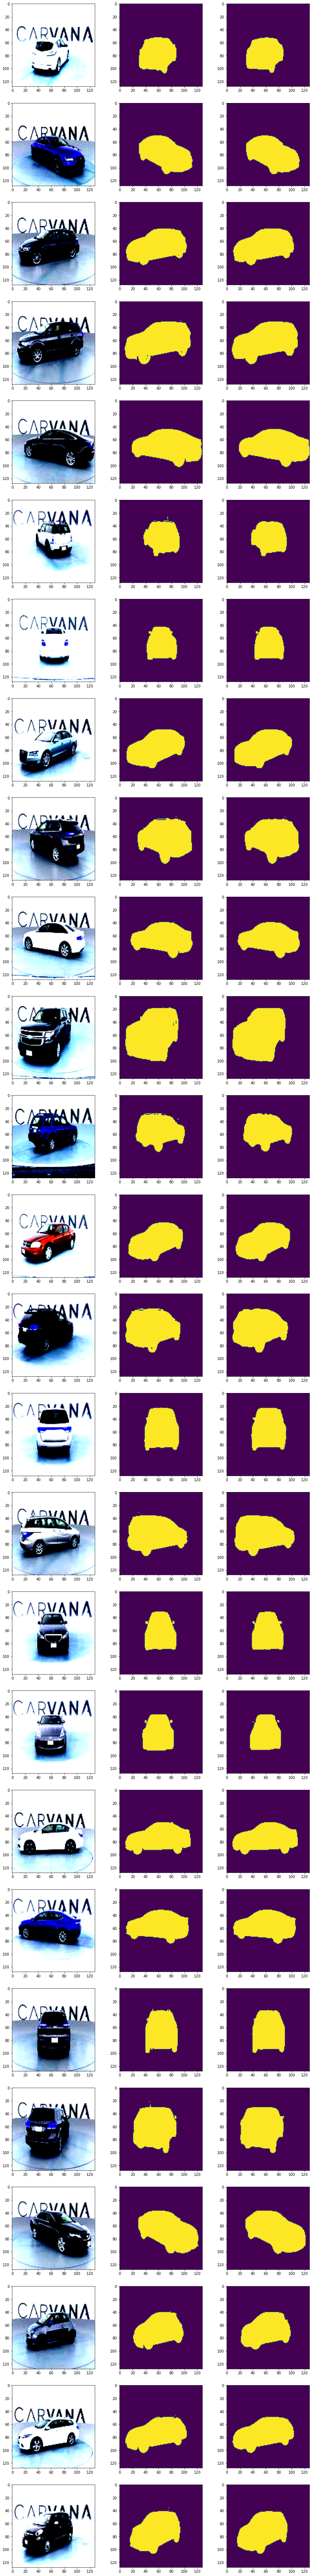

In [39]:
bs = 26
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i, (xb, yb) in enumerate(val_dl):
    with torch.no_grad():
        predb = unet(xb.cpu())
    ax[i][0].imshow(batch_to_img(xb,0))
    ax[i][1].imshow(yb[0])
    ax[i][2].imshow(predb_to_mask(predb, 0))
    if i==bs-1:
      break